In this homework you will build a real text --> image search engine! (yes, almost like real google image search).

To achieve this goal we will utilise CLIP framework and use CLIP image and text encoders to map images and texts to a unified vector space.

<img src='https://cdn.coveo.com/images/v1697655287/blogprod/169_Coveo_Vector-Search_FINAL_983515005d70/169_Coveo_Vector-Search_FINAL_983515005d70.jpg'>


Also, we will build a vector search index using a brilliant [FAISS](https://ai.meta.com/tools/faiss/) library. You also might want to read [this](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/) nice article about FAISS capabilities and how it works under the hood.

In [2]:
# Install required libraries
# For vector search engine we will use faiss
# https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/

!pip3 -qqq install torch
!pip3 -qqq install transformers
!pip3 -qqq install faiss-gpu
!pip3 -qqq install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.8 MB/s eta 0:00:00


In [3]:
from pathlib import Path
import numpy as np
import torch

# we will not need to train any models in this hometask
torch.set_grad_enabled(False)
import faiss
import requests

from PIL import Image
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
from datasets import load_dataset
from tqdm import tqdm_notebook

We will build our search engine based on a popular e-commerce dataset [fashion product images](https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset)

We will [the dataset version](https://huggingface.co/datasets/ashraq/fashion-product-images-small) with low resolution images to speed up downloading time.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/44072 [00:00<?, ? examples/s]

{'id': 15970, 'gender': 'Men', 'masterCategory': 'Apparel', 'subCategory': 'Topwear', 'articleType': 'Shirts', 'baseColour': 'Navy Blue', 'season': 'Fall', 'year': 2011.0, 'usage': 'Casual', 'productDisplayName': 'Turtle Check Men Navy Blue Shirt', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80 at 0x7D36511161A0>}


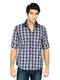

In [4]:
# Download the dataset (that might take ~10 mins) and check samples.

dataset = load_dataset("ashraq/fashion-product-images-small")
print(dataset['train'][0])
dataset['train'][0]['image']

<img src='https://miro.medium.com/v2/resize:fit:1158/1*tz_yyNvvna59tYDoqD4CUg.png' width=500>


A small reminder about CLIP.

CLIP consists of two models, image encoder and text encoder. The image encoder maps an input image to an image embedding (a vector, usually in $R^{512}$ or $R^{768}$ depending on a model version). The text encoder takes as input a text and outputs a text embedding with the same dimensionality as an image embedding.


CLIP trained in a way that the better a text decribes an image the closer an image embedding to a text embedding. Consequently, we can utilize this property to search over a database of images using text queries.

In [5]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# As a CLIP model we will use ViT model from OpenAI.
# Let's load the model.

MODEL_NAME = "openai/clip-vit-base-patch32"
EMBED_DIM = 512 # text and image embeddings dimensionality for this model

model = CLIPModel.from_pretrained(MODEL_NAME).to(device)
model = model.eval()
processor = CLIPProcessor.from_pretrained(MODEL_NAME)
tokenizer = CLIPTokenizer.from_pretrained(MODEL_NAME)

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [6]:
# Now it's time to compute image embeddings to build our own image search engine!
# For simplicity let's use only first 10_000 images from the dataset

img_dir = Path('./images/')
TOTAL_IMG_COUNT = 10_000

# <TASK>
np_index = np.zeros((TOTAL_IMG_COUNT, EMBED_DIM), dtype=np.float32)

for idx, img_record in enumerate(tqdm_notebook(dataset['train'], total=TOTAL_IMG_COUNT)):
    if idx >= TOTAL_IMG_COUNT:
        break;
    img = img_record['image']
    image = processor(images=img, return_tensors="pt").to(device)

    with torch.no_grad():
        image_embeddings = model.get_image_features(**image)

    np_index[idx, :] = image_embeddings.cpu().numpy()

print('embeddings index shape: ', np_index.shape)
assert np_index.shape == (TOTAL_IMG_COUNT, EMBED_DIM)

<ipython-input-6-f3189a0eb77c>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx, img_record in enumerate(tqdm_notebook(dataset['train'], total=TOTAL_IMG_COUNT)):


  0%|          | 0/10000 [00:00<?, ?it/s]

embeddings index shape:  (10000, 512)


In [7]:
print(np_index.shape)

(10000, 512)


In [9]:
# Built faiss search index with cosine distance as a similarity metrics.
# List of possible FAISS indexes https://github.com/facebookresearch/faiss/wiki/Faiss-indexes
# Don't forget to normalize your CLIP embeddings!


# <TASK>
# PASTER YOUR CODE HERE
norm_embeddings = np_index / np.linalg.norm(np_index, axis=1, keepdims=True)

d = EMBED_DIM
faiss_index = faiss.IndexFlatIP(d)

faiss_index.add(norm_embeddings.astype(np.float32))

print("FAISS index is ready with", faiss_index.ntotal, "embeddings.")

FAISS index is ready with 10000 embeddings.


In [10]:
def get_single_text_embedding(text: str, normalize=False):
    # <TASK>
    # Write a function that takes string as input and output CLIP text embedding.
    # Apply normalization if needed.

    # PASTER YOUR CODE HERE
    inputs = processor(text=text, return_tensors="pt", padding=True, truncation=True).to(device)

    with torch.no_grad():
        text_features = model.get_text_features(**inputs)

    text_embedding = text_features.cpu().numpy()
    if normalize:
        text_embedding = text_embedding / np.linalg.norm(text_embedding, axis=-1, keepdims=True)

    assert text_embedding.shape == (1, EMBED_DIM)
    if normalize:
        assert np.allclose(np.linalg.norm(text_embedding, axis=-1), 1.)
    return text_embedding

closest images have indices:  [[8815  705 8180]]


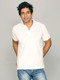

In [15]:
text_emb = get_single_text_embedding("photo of a man in white t-shirt", normalize=True)
scores, idx = faiss_index.search(text_emb, k=3)
print("closest images have indices: ", idx)

assert np.allclose(np.array(idx[0], dtype=np.int32), np.array([8815, 705, 8180]))
dataset['train'][int(idx[0][0])]['image']

In [12]:
# Notice that the same result we get if we simply run. Why? (just check you understand why).
np.argsort(text_emb @ np_index.T)[0][-3:][::-1]

array([8815, 8180, 7064])